In [1]:
# Imports

from datetime import datetime, timedelta

from sklearn.utils import shuffle
import numpy as np
import os

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Embedding, LSTM, Activation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Options

stocks = ['AAPL']

max_length = 20
vocab_size = 500

epochs = 100
batch_size = 16

In [3]:

def get_tick_data(stocks):
    """
    Tick Data
    
    This reads the high, lows, closes, etc. from data csv files
    """
    history = {}
    
    for stock in stocks:
        
        history[stock] = {}
        
        with open(os.path.join('..', 'data', stock + '.csv'), 'r') as data:

            for line in data:

                if len(line) > 6 and "Date" not in line and "null" not in line:

                    items = line.split(",")
                    
                    date = items[0]
                    data = np.array(list(map(float, items[1:]))) # 0, 1, 2, 4, 5 -> OPEN HIGH LOW ADJ_CLOSE VOLUME
                    
                    history[stock][date] = data
        
    return history


In [4]:

def get_headline_data(stocks):
    """
    Headline Data
    
    This reads the headlines from the headline csv file (created by CollectData)
    """
    history = {}
    
    with open(os.path.join('..', 'data', "_".join(stocks) + '-headlines.csv'), 'r', encoding="utf8") as data:
        
        for line in data:

            if len(line) > 6:

                stock, date, headline = line.split(",")
                
                if not stock in history:
                    
                    history[stock] = {}
                
                history[stock][date] = headline.replace('\n', '')
                
    return history


In [5]:

def make_headline_to_effect_data(tick_data, head_data):
    """
    Headline -> Effect
    
    Creates essentially the X, Y data for the embedding model to use
    when analyzing/encoding headlines. Returns a list of headlines and
    a list of corresponding 'effects' which represent a change in the stock price.
    """
    headlines, effects = [], []
    
    for stock, dates in head_data.items():
        
        for date, headline in dates.items():
            
            next_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)
            next_date = next_date.strftime('%Y-%m-%d')
            
            if date in tick_data[stock] and next_date in tick_data[stock]:
                
                tick_on = tick_data[stock][date]
                tick_after = tick_data[stock][next_date]
                
                if tick_after[3] >= tick_on[3]:
                    
                    effects.append([1., 0.])
                    
                else:
                    
                    effects.append([0., 1.])
                    
                headlines.append(headline)
                
    return headlines, np.array(effects)


In [6]:

def encode_sentences(sentences, max_length=16, vocab_size=None):
    """
    Encoder
    
    Takes a list of headlines and converts them into vectors
    """
    toke = Tokenizer(num_words=vocab_size)
    
    toke.fit_on_texts(sentences)
    
    encoded_headlines = toke.texts_to_sequences(sentences)
    
    padded_headlines = pad_sequences(encoded_headlines, maxlen=max_length, padding='post')
    
    return padded_headlines


In [7]:

def split_data(X, Y, ratio, mix=True):
    """
    Splits X/Y to Train/Test
    """
    
    if mix:
        
        X, Y = shuffle(X, Y)
        
    train_size = int(len(X) * ratio)
    trainX, testX = X[:train_size], X[train_size:]
    trainY, testY = Y[:train_size], Y[train_size:]
    
    return trainX, trainY, testX, testY


In [8]:

def get_model():
    
    model = Sequential()
    
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    
    model.add(LSTM(20))
    model.add(Activation('relu'))
    
    model.add(Dense(20))
    model.add(Activation('relu'))
    
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    return model


In [9]:

if __name__ == "__main__":
    
    tick_data = get_tick_data(stocks)
    head_data = get_headline_data(stocks)
    
    headlines, effects = make_headline_to_effect_data(tick_data, head_data)
    
    encoded_headlines = encode_sentences(headlines, max_length=max_length, vocab_size=vocab_size)
    
    trainX, trainY, testX, testY = split_data(encoded_headlines, effects, .8)
    
    print(trainX.shape, testY.shape)


(537, 20) (135, 2)


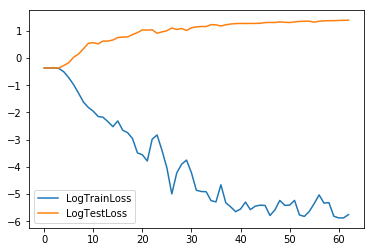

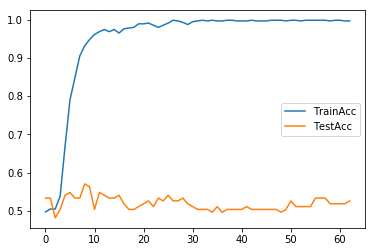

In [10]:

if __name__ == "__main__":
    
    model = get_model()
    
    e_stopping = EarlyStopping(monitor='val_loss', patience=60)
    
    history = model.fit(trainX, 
                        trainY, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(testX, testY),
                        verbose=0,
                        callbacks=[e_stopping])
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['LogTrainLoss', 'LogTestLoss'])
    plt.show()
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
    